# 9.6 Encoder-Decoder Architecture

In [37]:
from torch import nn
#@save
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

In [38]:
#@save
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

In [39]:
#@save
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# 10.1 Attention Cues

In [17]:
import torch
from d2l import torch as d2l

In [19]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
    cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
                fig.colorbar(pcm, ax=axes, shrink=0.6);

In [ ]:
torch.eye(2) # generate diagonal matrix (2-d tensor)

tensor([[1., 0.],
        [0., 1.]])

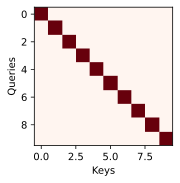

In [ ]:
# test show_heatmap function
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 10.2 Attention Pooling: Nadaraya-Watson Kernel Regression

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
n_train = 50 # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5) # Training inputs

In [24]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # Training outputs
x_test = torch.arange(0, 5, 0.1) # Testing examples
y_truth = f(x_test) # Ground-truth outputs for the testing examples
n_test = len(x_test) # No. of testing examples
n_test

50

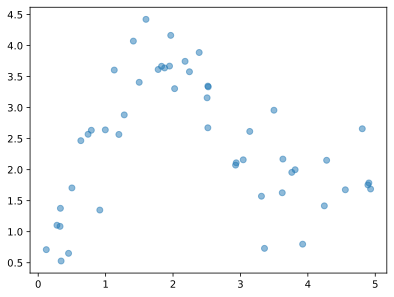

In [25]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', xlim=[0, 5], ylim=[-1, 5])
    
d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

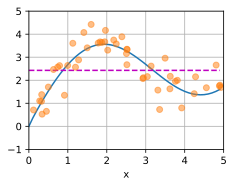

In [28]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)
d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## Nonparametric Average Pooling

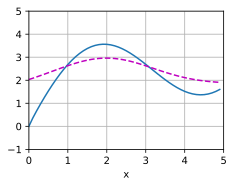

In [29]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

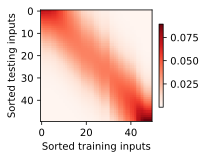

In [30]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs', 
                  ylabel='Sorted testing inputs')

# 10.5 Multi-head Attention

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [6]:
#@save
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value

    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
#@save
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
    
        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries, `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of `output_concat`: (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [2]:
#@save
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

#@save
def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [12]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [8]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

# 10.6 Self-Attention and Positional Encoding

In [9]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, 
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [14]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

# 10.7 Transformer

In [15]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
#@save
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, 
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [17]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
print(ffn(torch.ones((2, 3, 4))).shape) # operate on the last dimension
ffn(torch.ones((2, 3, 4)))[0]

torch.Size([2, 3, 8])


tensor([[-0.5483, -0.1222, -0.1000, -0.1114,  0.3479,  0.3728,  0.3302,  0.3910],
        [-0.5483, -0.1222, -0.1000, -0.1114,  0.3479,  0.3728,  0.3302,  0.3910],
        [-0.5483, -0.1222, -0.1000, -0.1114,  0.3479,  0.3728,  0.3302,  0.3910]],
       grad_fn=<SelectBackward0>)

## 10.7.3 Residual connection and Layer Normalisation

In [18]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [19]:
#@save
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [20]:
add_norm = AddNorm([3, 4], 0.5) # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 10.7.4 Encoder

In [24]:
#@save
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False,
                 **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [ ]:
# test output dimensions
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape
# should be the same as input shape

torch.Size([2, 100, 24])

In [27]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False,
                 **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
            
    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [28]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 10.7.5 Decoder

In [32]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
            
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [33]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [35]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for
        _
        in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 10.7.6 Training

loss 0.031, 5545.6 tokens/sec on cpu


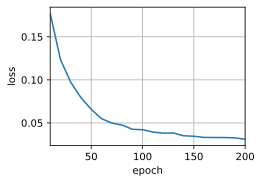

In [40]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Evaluation and Understanding

In [41]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', 
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [42]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

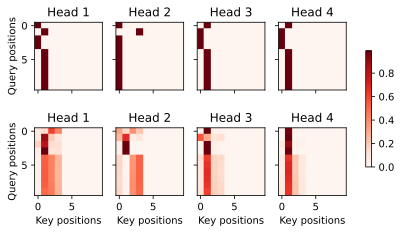

In [ ]:
# Visualise weights
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))